In [3]:
import sys
!{sys.executable} -m pip install deap

In [4]:
import sys
!{sys.executable} -m pip install pyswarms

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pyswarms as ps
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
from pyswarms.utils.functions import single_obj as fx
import random

# Load dataset from CSV
data = pd.read_csv('./eclipse.csv')

# Convert 'post' column to binary
data['post_binary'] = data['post'].apply(lambda x: 1 if x > 0 else 0)

# Prepare the feature matrix (X) and the target vector (y)
X = data.drop(columns=['plugin', 'filename', 'pre', 'post', 'post_binary'])  # Dropping non-numeric and target columns
y = data['post_binary']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Define the evaluation function for PSO
def evalFeatureSelection(x):
    n_particles = x.shape[0]
    fitness = []

    for i in range(n_particles):
        individual = [1 if val > 0.5 else 0 for val in x[i]]
        selected_features = [i for i, val in enumerate(individual) if val == 1]

        if len(selected_features) == 0:
            fitness.append(0)
            continue
        
        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]

        clf = SVC(probability=True)
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        fitness.append(accuracy)
    
    return np.array(fitness)

In [7]:
# Configure the PSO algorithm:
n_features = X_train.shape[1]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = (np.zeros(n_features), np.ones(n_features))
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=n_features, options=options, bounds=bounds)


In [8]:
# Run the PSO algorithm for feature selection:
cost, pos = optimizer.optimize(evalFeatureSelection, iters=20, verbose=True)

2023-10-08 10:19:41,296 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████|20/20, best_cost=0.846
2023-10-08 11:48:18,652 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8464443045940844, best pos: [0.69725352 0.43667875 0.4218525  0.73998591 0.9849148  0.68488707
 0.05673486 0.76813203 0.7388262  0.48005596 0.17006492 0.01680738
 0.45772268 0.21590149 0.61146529 0.53837587 0.63462634 0.6770709
 0.21761088 0.13514937 0.77358511 0.32151466 0.30073092 0.61327072
 0.91692499 0.35578665 0.89598975 0.41164597 0.0483733  0.01233507
 0.49212304 0.38581332 0.53847078 0.65027943 0.6418099  0.58472446
 0.91059173 0.29883636 0.31564968 0.51748632 0.9085981  0.43093683
 0.75048014 0.73790804 0.16368563 0.779624   0.73220325 0.78262715
 0.72726159 0.54446606 0.11995395 0.5613215  0.13064251 0.78341965
 0.91393154 0.82837565 0.67074755 0.73957171 0.41864317 0.91072679
 0.66472237 0.783

In [9]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = [1 if val > 0.5 else 0 for val in pos]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Number of selected features: ", len(selected_features))

Number of selected features:  101


In [10]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = SVC(probability=True)
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8464443045940844
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2690
           1       0.50      0.05      0.10       488

    accuracy                           0.85      3178
   macro avg       0.68      0.52      0.51      3178
weighted avg       0.80      0.85      0.79      3178



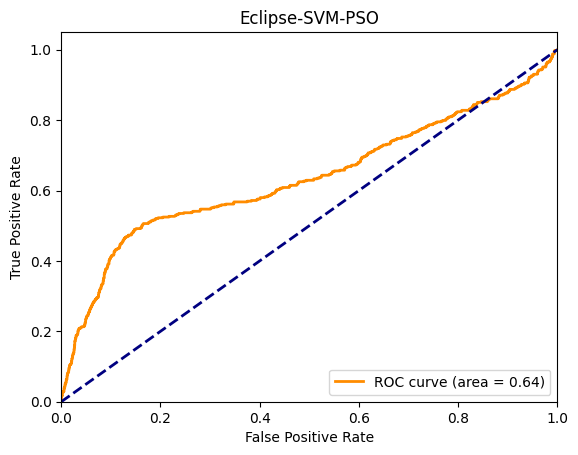

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/Eclipse/Eclipse_SVM_PSO.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eclipse-SVM-PSO')
plt.legend(loc="lower right")
plt.show()